In [123]:
import math
import numpy as np
import h5py
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
from tensorflow.python.framework import ops
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)
tf.set_random_seed(1)

In [138]:
# Load data
tic = time.time()

path = r'C:\Users\Nick Bashour\Documents\Personal\14. Stanford\2. Academics\3. 2021 Spring\1. CS 230\2. Project\3. Code\\'
X_train = np.genfromtxt(str(path+'out_X_train.csv'), delimiter=',')
Y_train = np.genfromtxt(str(path+'out_Y_train.csv'), delimiter=',')

X_test = np.genfromtxt(str(path+'out_X_test.csv'), delimiter=',')
Y_test = np.genfromtxt(str(path+'out_Y_test.csv'), delimiter=',')

toc = time.time()
print("time elapsed: " + str(toc-tic) + " sec's")

time elapsed: 31.45568823814392 sec's


In [124]:
# Create labels
labels = np.array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack - Brute Force', 'Web Attack - XSS',
       'Web Attack - Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [125]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
  
    Arguments:
    n_x -- scalar, size of input vector
    n_y -- scalar, number of classes
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"    
    """

    X = tf.placeholder(tf.float32, shape=[n_x,None], name="X")
    Y = tf.placeholder(tf.float32, shape=[n_y,None], name="Y")
        
    return X, Y

In [126]:
def initialize_parameters(L, param_sizes):
    """
    Initializes weight parameters 'W' using Xavier Initialization and bias parameters 'b' to zero.
    
    Arguments:
    L           -- the depth of the network
    param_sizes -- a dictionary of shapes for every parameter matrix W and b of every layer L
    
    Returns:
    parameters  -- a dictionary of tensors containing the initialized parameters
    """
    parameters = {}
    
    for i in range(L):
        W_curr = "W"+str(i+1)
        b_curr = "b"+str(i+1)
        parameters[W_curr] = tf.Variable(initial_value = np.random.randn(param_sizes[W_curr][0],param_sizes[W_curr][1])*0.01, name=W_curr, dtype=tf.float32, shape=param_sizes[W_curr])
        parameters[b_curr] = tf.Variable(initial_value = np.zeros(param_sizes[b_curr]), name=b_curr, dtype=tf.float32, shape=param_sizes[b_curr])
    
    return parameters

In [127]:
def forward_propagation(X, L, params):
    """
    Implements the forward propagation for a model with L-1 hidden ReLU layers and a Softmax in the last layer
    
    Arguments:    
    X      -- input dataset placeholder, of shape (input size, number of examples)
    L      -- total layers in the neural net
    params -- python dictionary containing W and b parameters

    Returns:
    Z3 -- the output of the last linear unit (does not calculate Softmax)
    """
    
    # Initialize activations to X and calculate
    a_curr = X
    l = 1
    while l <= L:
        w_curr = "W" + str(l)
        b_curr = "b" + str(l)
        z_curr = tf.add(tf.matmul(params[w_curr],a_curr), params[b_curr])        
        if(l < L):
                a_curr = tf.nn.relu(z_curr)
        l += 1
    
    # Return the output of the last linear unit
    return z_curr

In [128]:
def compute_cost(Z_final, Y):
    """
    Computes the softmax cross entropy cost
    
    Arguments:
    Z_final -- output of forward propagation (output of the last linear unit), of shape (# classes, # samples)
    Y       -- "true" labels vector placeholder, same shape as Z_final
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # transpose to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z_final)
    labels = tf.transpose(Y)    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
        
    return cost

In [137]:
def model(X_train, Y_train, X_test, Y_test, L, param_sizes, learning_rate = 0.0001,
          num_epochs = 500, minibatch_size = 128, print_cost = True):
    """
    Implements an L-layer tensorflow neural network where the first (L-1) layers are (Linear->ReLU)
    and the final layer is a (Linear->Softmax)
    
    Arguments:
    X_train        -- training set, of shape (# of features, training samples)
    Y_train        -- test set, of shape (# of classes, training samples)
    X_test         -- training set, of shape (# of features, test samples)
    Y_test         -- test set, of shape (# of classes, test samples)
    L              -- number of layers in the network
    param_sizes    -- dictionary of matrix shapes for all parameters W and b, with keys "W1", "b1", etc.
    learning_rate  -- learning rate of the optimization, default to 0.0001
    num_epochs     -- number of epochs of the optimization loop, default to 500
    minibatch_size -- size of a minibatch, default to 128
    print_cost     -- boolean to print the cost every 100 epochs, default to True
    
    Returns:
    params -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                            # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    X, Y = create_placeholders(n_x, n_y)
    params = initialize_parameters(L, param_sizes)
    Z_final = forward_propagation(X, L, params)
    cost = compute_cost(Z_final, Y)
    # AdamOptimizer for gradient descent
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
        
    # Initialize the session
    init = tf.global_variables_initializer()

    # Run the training loop across epochs
    with tf.Session() as sess:      
        
        sess.run(init)        
        tic = time.time()
        for epoch in range(num_epochs):
            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) 
            
            for i in range(num_minibatches):
                
                minibatch_X = X_train[:,minibatch_size*(i-1):minibatch_size*i]
                minibatch_Y = Y_train[:,minibatch_size*(i-1):minibatch_size*i]             
                _ , minibatch_cost = sess.run([optimizer,cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})                                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost and time elapsed every 100 epochs, store it every 5
            if print_cost == True and epoch % 100 == 0:
                toc = time.time()
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                print ("Time elapsed: " + str(int(toc-tic)) + " seconds")
                tic = time.time()
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs (per fives)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        params = sess.run(params)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z_final), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return params

Cost after epoch 0: nan
Time elapsed: 0 seconds


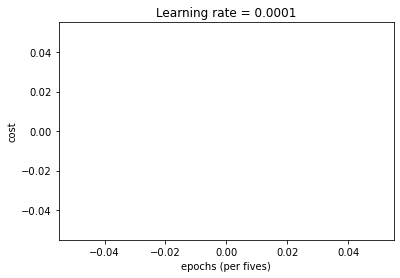

Parameters have been trained!
Train Accuracy: 0.99972653
Test Accuracy: 1.0


In [144]:
# ------------ MODEL TRAINING -----------------------------------
L = 5
(nx, m) = X_train.shape
ny = Y_train.shape[0]
param_sizes = {
    "W1": (30,nx),
    "b1": (30,1),
    "W2": (24,30),
    "b2": (24,1),
    "W3": (16,24),
    "b3": (16,1),
    "W4": (10,16),
    "b4": (10,1),
    "W5": (ny,10),
    "b5": (ny,1),
}

parameters = model(X_train, Y_train, X_test, Y_test, L, param_sizes, num_epochs = 100)

In [131]:
# ------------ TESTING /DEBUGGING -----------------------------------
# -------------------------------------------------------------------
# -------------------------------------------------------------------

# ------------ Individual functions ---------------------------------
# L = 2
# param_sizes = {}
# param_sizes["W1"] = (4,3)
# param_sizes["b1"] = (4,1)
# param_sizes["W2"] = (5,4)
# param_sizes["b2"] = (5,1)
# parameters = initialize_parameters(L, param_sizes)
# X = np.random.randn(3,5)
# Y = np.random.randn(5,5)
# Z2 = forward_propagation(X, L, parameters)
# cost = compute_cost(Z2, Y)
# print(cost)

# ------------ Entire model -----------------------------------------
# L = 4
# X_train_0 = np.random.randn(3,5)
# Y_train_0 = np.random.randn(4,5)
# X_test_0 = np.random.randn(3,2)
# Y_test_0 = np.random.randn(4,2)

# param_sizes = {
#     "W1": (4,3),
#     "b1": (4,1),
#     "W2": (5,4),
#     "b2": (5,1),
#     "W3": (3,5),
#     "b3": (3,1),
#     "W4": (4,3),
#     "b4": (4,1),
# }

# parameters = model(X_train_0, Y_train_0, X_test_0, Y_test_0, L, param_sizes, num_epochs = 1000)